In [35]:
# 75.06 - 1C202 - TP2 
# Competencia de Machine learning
#
# https://www.kaggle.com/c/nlp-getting-started/overview
#
# Fuentes:
# https://realpython.com/python-keras-text-classification/
# https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

# Importacion de librerias necesarias
import re, string, random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK
# https://www.nltk.org
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 

# NLPAUG
# https://github.com/makcedward/nlpaug
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

# Split y K-Fold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Importacion de Keras
# https://keras.io
from keras.models import Sequential, save_model, load_model
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Configuracion general
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [36]:
# Seccion de CONFIGURACION

# Path de entrada
train_path = 'data/train.csv'
test_path = 'data/test.csv'

# Configuracion del modelo
maxlen = 100
num_filters = 32
kernel_size = 8
embedding_dim = 200
embeddings_path = 'embeddings/glove.twitter.27B.200d.txt'
# Embeddings disponibles en:
# https://worksheets.codalab.org/bundles/0x4090ba96b8a444c2a44b2c47884c25f2

# Configuracion de entrenamiento
num_folds = 3
epochs = 1
verbose = False
batch_size = 1

# Path de para guardar los modelos
model_path = 'models/TP2.Keras.Conv1D.Iter.'

# Path de salida para el submission
submission_path = 'data/submits/submission_grid_search_20200801.csv'

In [37]:
# Funciones AUXILIARES

# Pasa un texto a lowercase
def lowercase_text(text):
    return text.lower()

# Limpia los datos, mediante el uso de expresiones regulares
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Grafica para un modelo los resultados del entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validación')
    plt.title('Accuracy: validación y entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validación')
    plt.title('Loss: validación y entrenamiento')
    plt.legend()
    plt.show()

# Genera la matriz de embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # 0 es un indice reservado, sumamos 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

# Define el modelo a utilizar, con Conv1D
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [38]:
# Carga de los archivos del set de datos

# Set de train: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_train = pd.read_csv(train_path, sep=',')
#Sumo los keywords al text
df_twitter_train['keyword'].fillna(' ', inplace=True)
df_twitter_train['text'] = (df_twitter_train['text'] + ' ' + df_twitter_train['keyword'])
df_twitter_train.drop('location', axis=1, inplace=True)
df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: lowercase_text(x))
df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: remove_noise(x))


# Set de test: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_test = pd.read_csv(test_path, sep=',')
#Sumo los keywords al text
df_twitter_test['keyword'].fillna(' ', inplace=True)
df_twitter_test['text'] = (df_twitter_test['text'] + ' ' + df_twitter_test['keyword'])
df_twitter_test.drop('location', axis=1, inplace=True)
df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: lowercase_text(x))
df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: remove_noise(x))

# Vemos el tamaño de ambos sets
print(df_twitter_train.shape)
print(df_twitter_test.shape)

(7613, 4)
(3263, 3)


In [39]:
df_twitter_train.head()

,id,keyword,text,target
0,1,,our deeds are the reason of this earthquake ma...,1
1,4,,forest fire near la ronge sask canada,1
2,5,,all residents asked to shelter in place are be...,1
3,6,,people receive wildfires evacuation orders in...,1
4,7,,just got sent this photo from ruby alaska as s...,1


In [40]:
df_twitter_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7613 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


In [41]:
# Tratamiento del set con nltk y nlpaug
# NLTK
# Sabiendo que todos los tweets son en idioma ingles, quitamos las stopwords
stop_words = set(stopwords.words('english'))
df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


# NLPAUG
# Tratamiento del set de train con nlpaug
# Aumentamos el tamaño de nuestro set para mejorar los resultados de la prediccion

# Creamos un nuevo dataframe para trabajar
df_twitter_train_aug = pd.DataFrame(df_twitter_train)

# Reemplazamos una palabra del tweet con un sinonimo tomado de WordNet
aug_syn = naw.SynonymAug(aug_src='wordnet')
# Intercambiamos una palabra random por otra en el tweet
aug_swp = naw.RandomWordAug(action="swap")

# Usamos las 2 opciones
#df_twitter_train_aug['text'] = df_twitter_train_aug['text'].apply(lambda x: aug_syn.augment(x))
#df_twitter_train_aug['text'] = df_twitter_train_aug['text'].apply(lambda x: aug_swp.augment(x))

# Unimos los 2 dataframes
#df_twitter_train_aug = pd.concat([df_twitter_train, df_twitter_train_aug])

# Stemmizamos los textos de los tweets
#ps = PorterStemmer()
#df_twitter_train_aug['text'] =  df_twitter_train_aug['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
#df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

# Lematizamos los textos de los tweets
lem = WordNetLemmatizer()
df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))
df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))


# Vemos el tamaño final del set de train
print(df_twitter_train_aug.shape)

(7613, 4)


In [42]:
# Vemos como quedo el set de train
df_twitter_train_aug.head()

,id,keyword,text,target
0,1,,deeds reason earthquake may allah forgive us,1
1,4,,forest fire near la ronge sask canada,1
2,5,,residents ask shelter place notify officer eva...,1
3,6,,people receive wildfires evacuation order cali...,1
4,7,,get send photo ruby alaska smoke wildfires pou...,1


In [43]:
# Vemos como quedo el set de test
df_twitter_test.head()

,id,keyword,text
0,0,,happen terrible car crash
1,2,,hear earthquake different cities stay safe eve...
2,3,,forest fire spot pond geese flee across street...
3,9,,apocalypse light spokane wildfires
4,11,,typhoon soudelor kill china taiwan


In [44]:
# Nos quedamos con X e y para entrenar
tweets = df_twitter_train_aug['text'].values
y = df_twitter_train_aug['target'].values

# Separamos X para el set de test
tweets_predict = df_twitter_test['text'].values
keyword_predict = df_twitter_test['keyword'].values

In [45]:
# Tokenizamos los textos
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)

# Convertimos a secuencias
X = tokenizer.texts_to_sequences(tweets)
X_predict = tokenizer.texts_to_sequences(tweets_predict)

# Calculamos el tamaño
vocab_size = len(tokenizer.word_index) + 1  # 0 es un indice reservado, sumamos 1

#PROBAR CON EL TOKENIZADOR DE NTK DE TWITTER

In [46]:
# Paddeamos a maxlen
X = pad_sequences(X, padding='post', maxlen=maxlen)
X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

In [47]:
# Generacion de la matriz de embeddings
embedding_matrix = create_embedding_matrix(embeddings_path,tokenizer.word_index, embedding_dim)

# Vemos que cobertura tenemos con los embeddings utilizados
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Cobertura de vocabulario: ' + str(nonzero_elements / vocab_size))

Cobertura de vocabulario: 0.7095033135205302


------------------------------------------------------------------------
Entrenando, fold 1...
epochs:  1
batch_size:  1
Puntaje de entrenamiento para el fold 1: loss de 0.3059696555137634; accuracy de 88.80788087844849%
Puntaje de validación para el fold 1: loss de 0.4518145024776459; accuracy de 79.70843315124512%


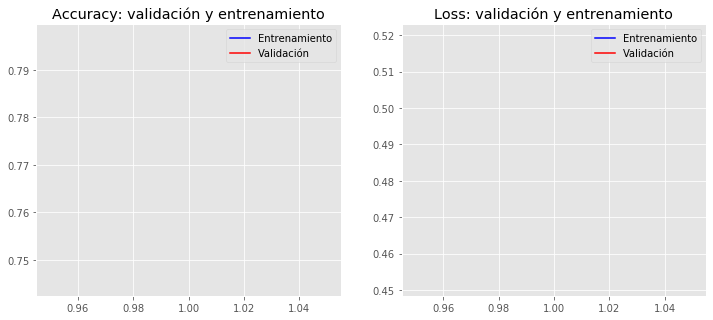

------------------------------------------------------------------------
Entrenando, fold 2...
epochs:  1
batch_size:  2
Puntaje de entrenamiento para el fold 2: loss de 0.3106469511985779; accuracy de 89.18226361274719%
Puntaje de validación para el fold 2: loss de 0.45384567975997925; accuracy de 80.06303906440735%


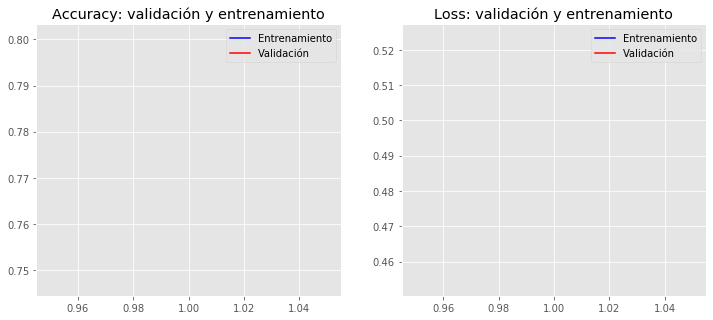

------------------------------------------------------------------------
Entrenando, fold 3...
epochs:  1
batch_size:  3
Puntaje de entrenamiento para el fold 3: loss de 0.30643191933631897; accuracy de 88.33497762680054%
Puntaje de validación para el fold 3: loss de 0.45630383491516113; accuracy de 80.02364039421082%


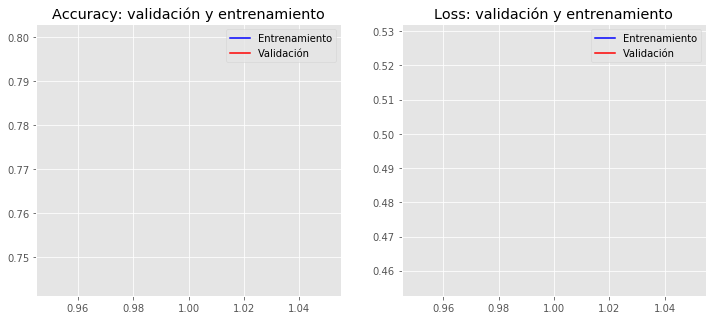

------------------------------------------------------------------------
Entrenando, fold 4...
epochs:  1
batch_size:  4
Puntaje de entrenamiento para el fold 4: loss de 0.3142896592617035; accuracy de 89.28079009056091%
Puntaje de validación para el fold 4: loss de 0.4506632387638092; accuracy de 80.22064566612244%


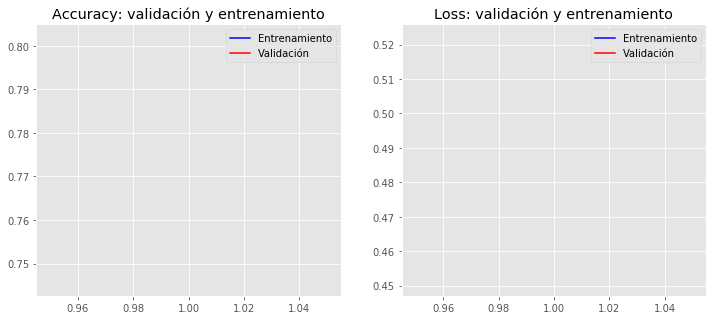

------------------------------------------------------------------------
Entrenando, fold 5...
epochs:  1
batch_size:  5
Puntaje de entrenamiento para el fold 5: loss de 0.3525596857070923; accuracy de 89.63546752929688%
Puntaje de validación para el fold 5: loss de 0.46925902366638184; accuracy de 80.02364039421082%


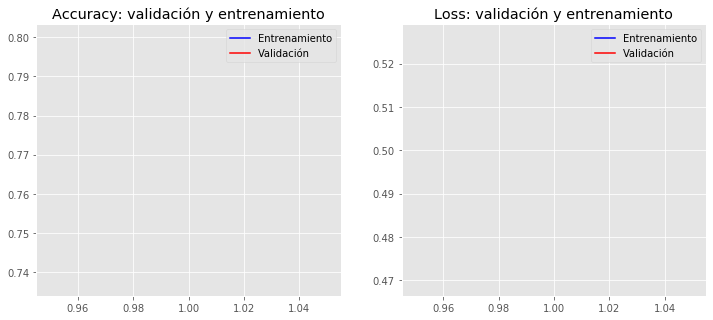

------------------------------------------------------------------------
Entrenando, fold 6...
epochs:  1
batch_size:  6
Puntaje de entrenamiento para el fold 6: loss de 0.29966577887535095; accuracy de 89.37931060791016%
Puntaje de validación para el fold 6: loss de 0.4481804370880127; accuracy de 79.86603379249573%


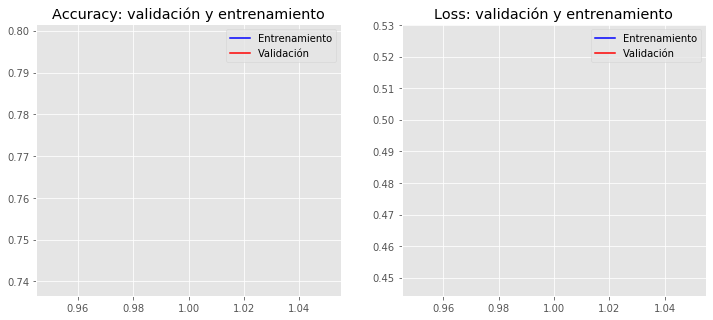

------------------------------------------------------------------------
Entrenando, fold 7...
epochs:  1
batch_size:  7
Puntaje de entrenamiento para el fold 7: loss de 0.30178454518318176; accuracy de 88.90640139579773%
Puntaje de validación para el fold 7: loss de 0.4494384527206421; accuracy de 80.45705556869507%


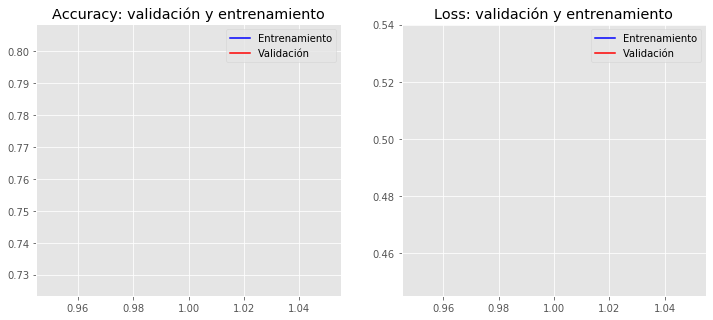

------------------------------------------------------------------------
Entrenando, fold 8...
epochs:  1
batch_size:  8
Puntaje de entrenamiento para el fold 8: loss de 0.3103489875793457; accuracy de 88.33497762680054%
Puntaje de validación para el fold 8: loss de 0.443972647190094; accuracy de 79.8266351222992%


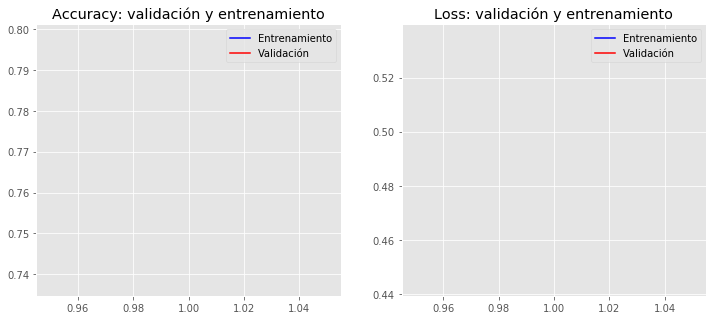

------------------------------------------------------------------------
Entrenando, fold 9...
epochs:  1
batch_size:  9
Puntaje de entrenamiento para el fold 9: loss de 0.48391807079315186; accuracy de 85.04433631896973%
Puntaje de validación para el fold 9: loss de 0.5570732355117798; accuracy de 77.73837447166443%


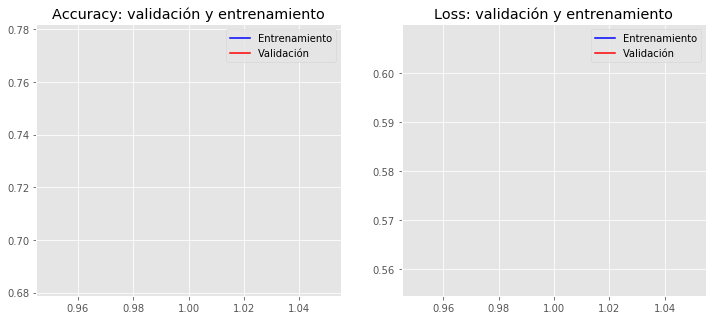

------------------------------------------------------------------------
Entrenando, fold 10...
epochs:  2
batch_size:  1
Puntaje de entrenamiento para el fold 10: loss de 0.18834808468818665; accuracy de 93.83251070976257%
Puntaje de validación para el fold 10: loss de 0.47382837533950806; accuracy de 78.80220413208008%


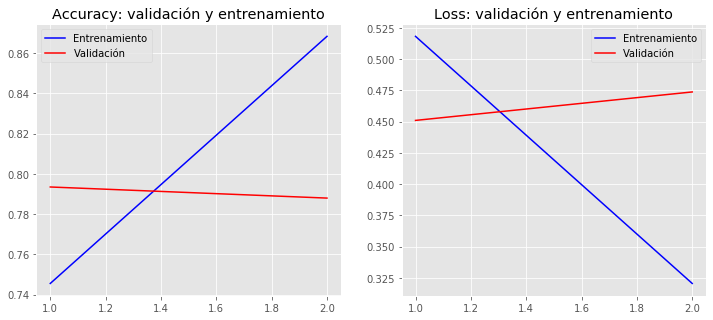

------------------------------------------------------------------------
Entrenando, fold 11...
epochs:  2
batch_size:  2
Puntaje de entrenamiento para el fold 11: loss de 0.15237101912498474; accuracy de 94.18719410896301%
Puntaje de validación para el fold 11: loss de 0.5067220330238342; accuracy de 79.47202324867249%


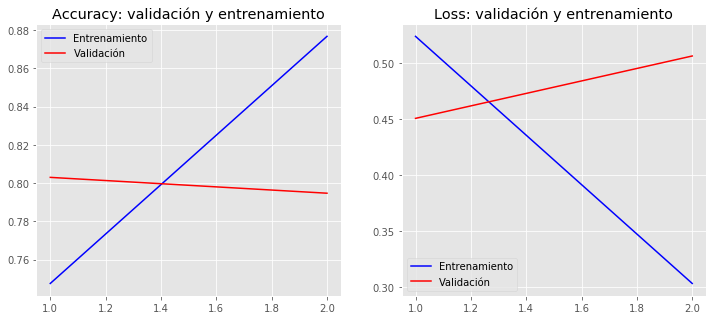

------------------------------------------------------------------------
Entrenando, fold 12...
epochs:  2
batch_size:  3
Puntaje de entrenamiento para el fold 12: loss de 0.15785421431064606; accuracy de 93.81280541419983%
Puntaje de validación para el fold 12: loss de 0.5318505167961121; accuracy de 79.03861403465271%


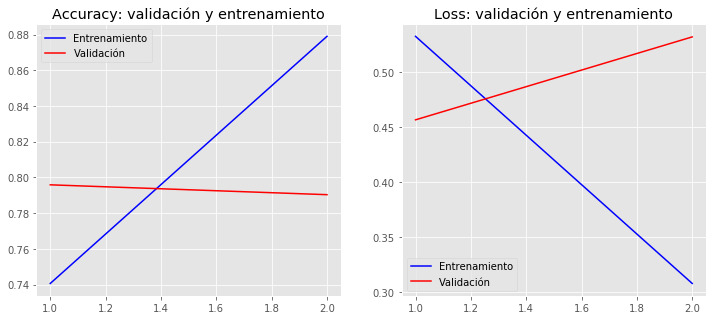

------------------------------------------------------------------------
Entrenando, fold 13...
epochs:  2
batch_size:  4
Puntaje de entrenamiento para el fold 13: loss de 0.15520808100700378; accuracy de 94.95566487312317%
Puntaje de validación para el fold 13: loss de 0.48564413189888; accuracy de 78.56580018997192%


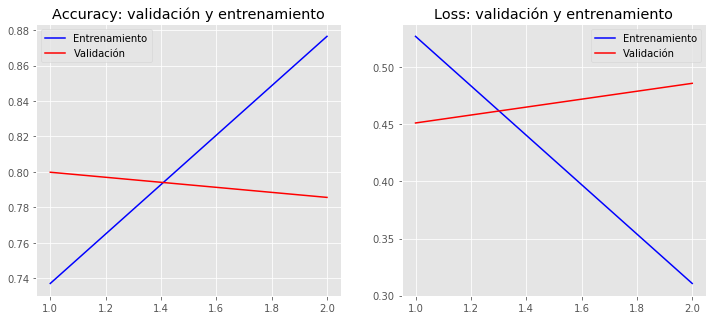

------------------------------------------------------------------------
Entrenando, fold 14...
epochs:  2
batch_size:  5
Puntaje de entrenamiento para el fold 14: loss de 0.16063697636127472; accuracy de 95.13300657272339%
Puntaje de validación para el fold 14: loss de 0.49254125356674194; accuracy de 79.07801270484924%


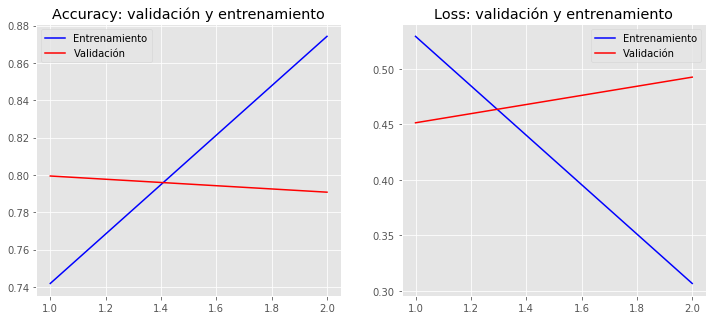

------------------------------------------------------------------------
Entrenando, fold 15...
epochs:  2
batch_size:  6
Puntaje de entrenamiento para el fold 15: loss de 0.1720043569803238; accuracy de 94.305419921875%
Puntaje de validación para el fold 15: loss de 0.5006240010261536; accuracy de 78.56580018997192%


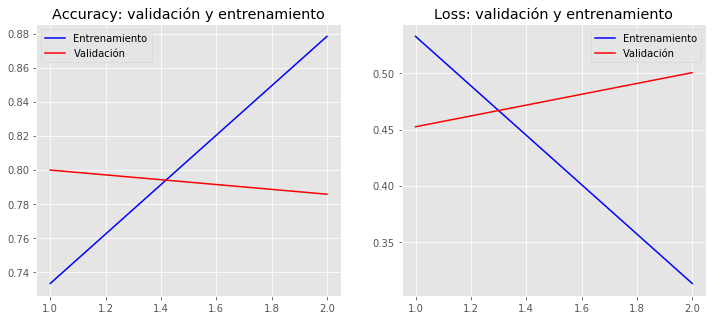

------------------------------------------------------------------------
Entrenando, fold 16...
epochs:  2
batch_size:  7
Puntaje de entrenamiento para el fold 16: loss de 0.16969135403633118; accuracy de 95.03448009490967%
Puntaje de validación para el fold 16: loss de 0.4919396638870239; accuracy de 78.52640151977539%


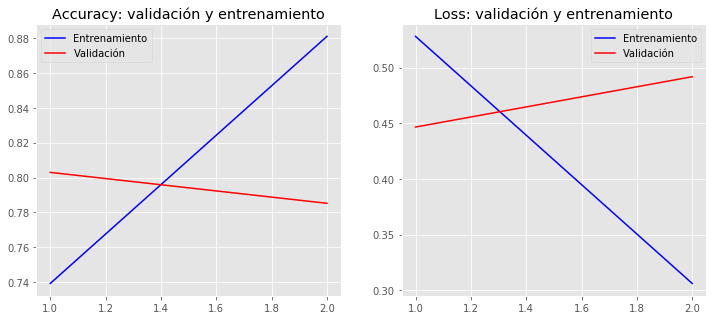

------------------------------------------------------------------------
Entrenando, fold 17...
epochs:  2
batch_size:  8
Puntaje de entrenamiento para el fold 17: loss de 0.17503446340560913; accuracy de 94.22659873962402%
Puntaje de validación para el fold 17: loss de 0.4710111916065216; accuracy de 79.55082654953003%


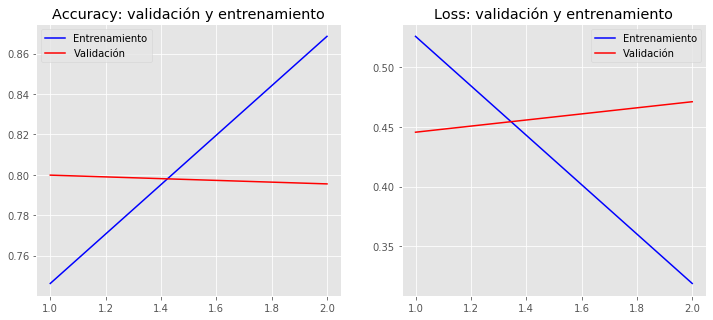

------------------------------------------------------------------------
Entrenando, fold 18...
epochs:  2
batch_size:  9
Puntaje de entrenamiento para el fold 18: loss de 0.1739349514245987; accuracy de 94.46305632591248%
Puntaje de validación para el fold 18: loss de 0.47495022416114807; accuracy de 79.07801270484924%


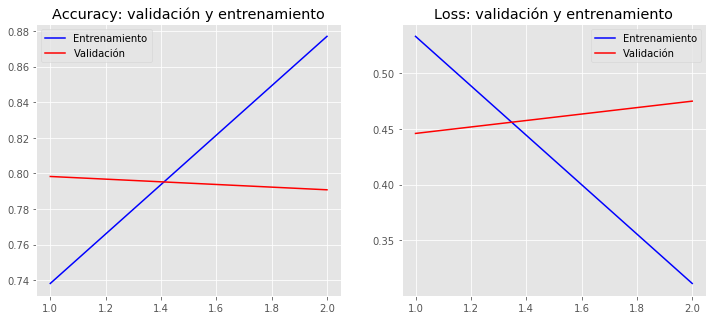

------------------------------------------------------------------------
Entrenando, fold 19...
epochs:  3
batch_size:  1
Puntaje de entrenamiento para el fold 19: loss de 0.1031867191195488; accuracy de 96.295565366745%
Puntaje de validación para el fold 19: loss de 0.5612859725952148; accuracy de 78.32939028739929%


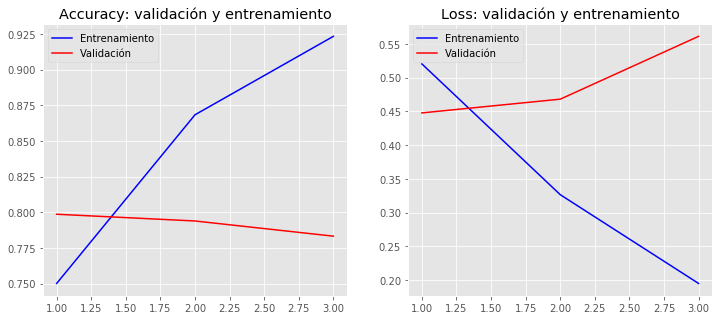

------------------------------------------------------------------------
Entrenando, fold 20...
epochs:  3
batch_size:  2
Puntaje de entrenamiento para el fold 20: loss de 0.09489244222640991; accuracy de 96.63054347038269%
Puntaje de validación para el fold 20: loss de 0.6003317832946777; accuracy de 75.09850263595581%


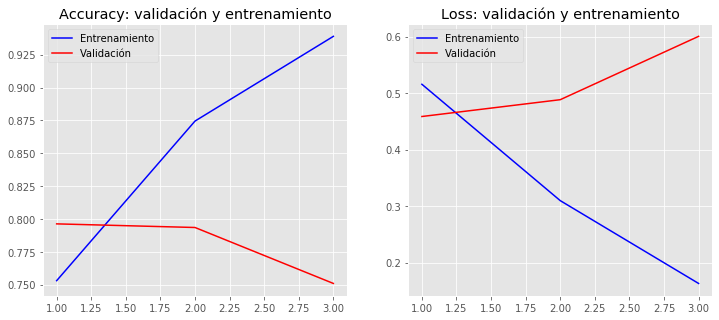

------------------------------------------------------------------------
Entrenando, fold 21...
epochs:  3
batch_size:  3
Puntaje de entrenamiento para el fold 21: loss de 0.09307701140642166; accuracy de 96.49261236190796%
Puntaje de validación para el fold 21: loss de 0.5910006761550903; accuracy de 77.6989758014679%


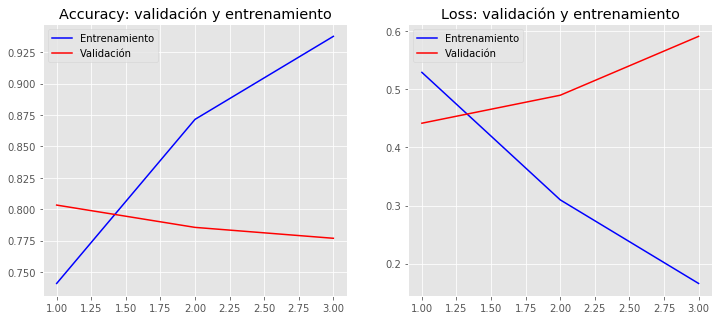

------------------------------------------------------------------------
Entrenando, fold 22...
epochs:  3
batch_size:  4
Puntaje de entrenamiento para el fold 22: loss de 0.08786972612142563; accuracy de 97.02463150024414%
Puntaje de validación para el fold 22: loss de 0.579524576663971; accuracy de 76.83215141296387%


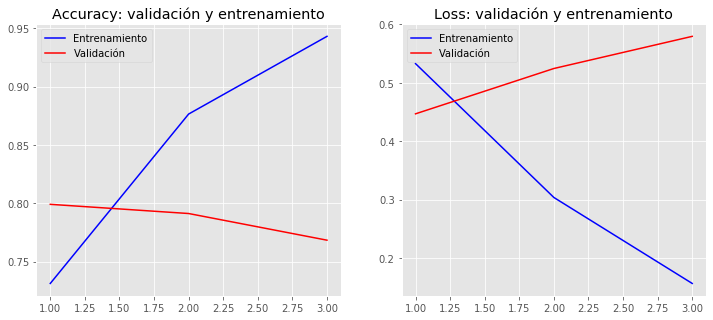

------------------------------------------------------------------------
Entrenando, fold 23...
epochs:  3
batch_size:  5
Puntaje de entrenamiento para el fold 23: loss de 0.08537282794713974; accuracy de 96.9261109828949%
Puntaje de validación para el fold 23: loss de 0.5975548624992371; accuracy de 77.18676328659058%


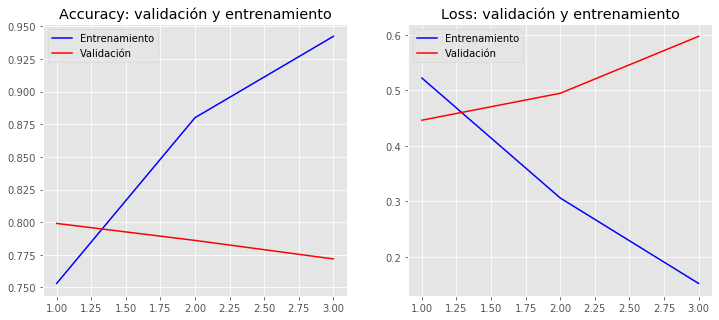

------------------------------------------------------------------------
Entrenando, fold 24...
epochs:  3
batch_size:  6
Puntaje de entrenamiento para el fold 24: loss de 0.10846491903066635; accuracy de 96.53201699256897%
Puntaje de validación para el fold 24: loss de 0.5492253303527832; accuracy de 77.77777910232544%


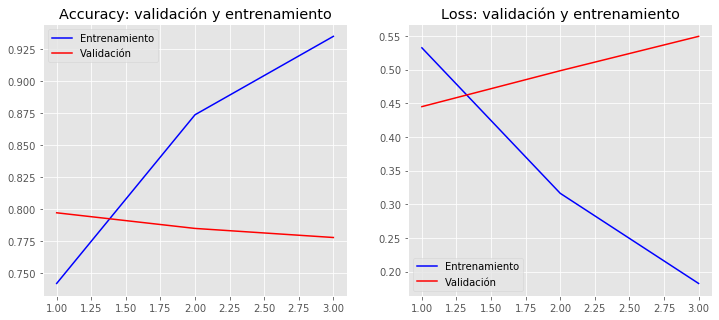

------------------------------------------------------------------------
Entrenando, fold 25...
epochs:  3
batch_size:  7
Puntaje de entrenamiento para el fold 25: loss de 0.09534122794866562; accuracy de 96.37438654899597%
Puntaje de validación para el fold 25: loss de 0.5984625816345215; accuracy de 77.3837685585022%


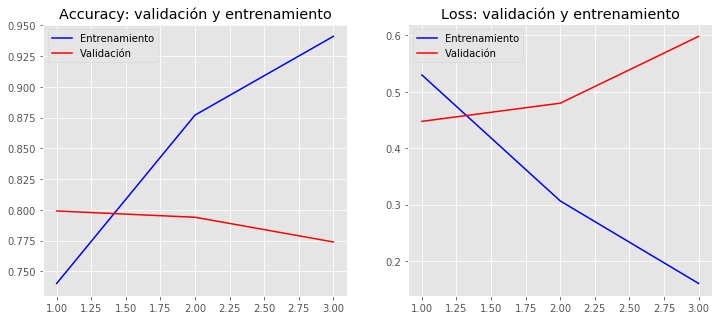

------------------------------------------------------------------------
Entrenando, fold 26...
epochs:  3
batch_size:  8
Puntaje de entrenamiento para el fold 26: loss de 0.09467000514268875; accuracy de 96.47290706634521%
Puntaje de validación para el fold 26: loss de 0.6248496174812317; accuracy de 78.56580018997192%


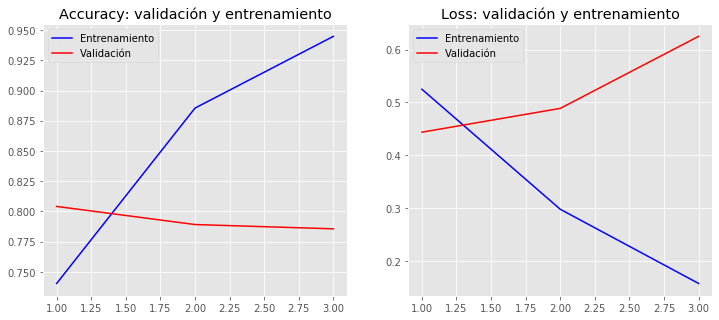

------------------------------------------------------------------------
Entrenando, fold 27...
epochs:  3
batch_size:  9
Puntaje de entrenamiento para el fold 27: loss de 0.09798165410757065; accuracy de 97.20197319984436%
Puntaje de validación para el fold 27: loss de 0.5565865635871887; accuracy de 77.62017250061035%


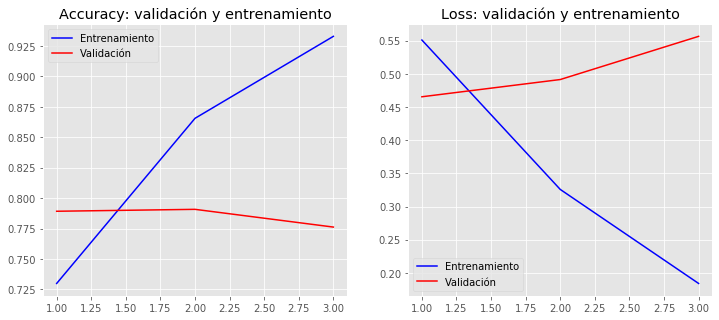



Puntaje promedio de entrenamiendo, para todos los folds:
> Accuracy: 93.21510703475387 (+- 3.521330203284049)
> Loss: 0.19820575140140675


Puntaje promedio de validación, para todos los folds:
> Accuracy: 78.7073517287219 (+- 1.2290250477243478)
> Loss: 0.513647570654198
------------------------------------------------------------------------


In [48]:
# Definimos y entrenamos el modelo
# K-Fold Cross Validation

# Definimos los arrays para guardar los resultados
# Train
acc_per_fold_train = []
loss_per_fold_train = []
# Validacion
acc_per_fold_validation = []
loss_per_fold_validation = []

# Definomos el K-fold Cross Validator a usar
kfold = KFold(n_splits=num_folds, shuffle=True)

# Hacemos el bucle para la cantidad de folds definidos
fold_no = 1
for train, validation in kfold.split(X, y):

    while(epochs < 10):
        batch_size = 1
        while (batch_size < 10):
            # Imprimimos el progreso
            print('------------------------------------------------------------------------')
            print(f'Entrenando, fold {fold_no}...')
            print('epochs: ', epochs)
            print('batch_size: ', batch_size)

            # Definimos la arquitectura del modelo
            model = create_model(num_filters = num_filters,
                                 kernel_size = kernel_size,
                                 vocab_size = vocab_size,
                                 embedding_dim = embedding_dim,
                                 maxlen = maxlen)

                # Hacemos el fit
            history = model.fit(X[train], y[train],
                                epochs = epochs,
                                verbose = verbose,
                                validation_data = (X[validation], y[validation]),
                                batch_size = batch_size)      

            # Generamos la metrica de entrenamiento
            scores_train = model.evaluate(X[train], y[train], verbose=0)
            print(f'Puntaje de entrenamiento para el fold {fold_no}: {model.metrics_names[0]} de {scores_train[0]}; {model.metrics_names[1]} de {scores_train[1]*100}%')
            acc_per_fold_train.append(scores_train[1] * 100)
            loss_per_fold_train.append(scores_train[0])

            # Generamos la metrica de test
            scores_validation = model.evaluate(X[validation], y[validation], verbose=0)
            print(f'Puntaje de validación para el fold {fold_no}: {model.metrics_names[0]} de {scores_validation[0]}; {model.metrics_names[1]} de {scores_validation[1]*100}%')
            acc_per_fold_validation.append(scores_validation[1] * 100)
            loss_per_fold_validation.append(scores_validation[0])

            # Guardamos el modelo
            save_model(model, model_path + str(fold_no) + '.h5', save_format='h5')

            # Plotteamos el resultado final
            plot_history(history)

            # Incrementamos
            fold_no = fold_no + 1
            batch_size = batch_size + 1
        
        epochs = epochs + 1

    
print('\n')
print('Puntaje promedio de entrenamiendo, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_train)} (+- {np.std(acc_per_fold_train)})')
print(f'> Loss: {np.mean(loss_per_fold_train)}')
print('\n')
print('Puntaje promedio de validación, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_validation)} (+- {np.std(acc_per_fold_validation)})')
print(f'> Loss: {np.mean(loss_per_fold_validation)}')
print('------------------------------------------------------------------------')

In [49]:
# Cargamos el modelo con el mejor puntaje
filepath = model_path + str((acc_per_fold_validation.index(max(acc_per_fold_validation)))+1) + '.h5'
loaded_model = load_model(filepath, custom_objects=None, compile=True)

# Imprimimos el detalle del modelo utilizado
loaded_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 200)          2927400   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 93, 32)            51232     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 11        
Total params: 2,978,973
Trainable params: 2,978,973
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Prediccion en base al modelo entrenado
y_predict = (loaded_model.predict(X_predict) > 0.5).astype('int32')

In [51]:
# Generacion del dataframe que generara el submit para la competencia
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = y_predict
kaggle_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [52]:
# Escritura del submit en formato CSV
kaggle_submission.to_csv(submission_path, index=False)

In [33]:
# ToDo:
# Grid search, busqueda de hiper-parametros ideales